In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('./release/')

In [4]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR, StepLR
import torch.nn.functional as F

In [5]:
use_cuda = torch.cuda.is_available()
use_cuda

True

In [6]:
import numpy as np
from tqdm import tqdm, trange
import pickle
from rdkit import Chem, DataStructs
from stackRNN import StackAugmentedRNN
from data import GeneratorData
from utils import canonical_smiles

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [8]:
#gen_data_path = './data/chembl_22_clean_1576904_sorted_std_final.smi'
gen_data_path = './data/PI1M.csv'

In [9]:
import warnings

warnings.filterwarnings('ignore')

In [10]:
import json

# 定义字典
word_index = '{"C": 1, "(": 2, ")": 3, "c": 4, "*": 5, "O": 6, "=": 7, "1": 8, "N": 9, "S": 10, "/": 11, "[": 12, "]": 13, "F": 14, "2": 15, "#": 16, "l": 17, "i": 18, "H": 19, "n": 20, "P": 21, "B": 22, "r": 23, "+": 24, "-": 25, "s": 26, "\\\\": 27, "e": 28, "I": 29, "o": 30, "G": 31, "a": 32, "3": 33, "A": 34, "Z": 35, "b": 36, "d": 37, "K": 38, "T": 39, "p": 40, "4": 41}'

# 将字符串转换为字典
word_index_dict = json.loads(word_index)

# 提取键
keys = word_index_dict.keys()

# 打印结果
print(keys)

dict_keys(['C', '(', ')', 'c', '*', 'O', '=', '1', 'N', 'S', '/', '[', ']', 'F', '2', '#', 'l', 'i', 'H', 'n', 'P', 'B', 'r', '+', '-', 's', '\\', 'e', 'I', 'o', 'G', 'a', '3', 'A', 'Z', 'b', 'd', 'K', 'T', 'p', '4'])


In [11]:
# #tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
#           '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
#           '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n','M','*','L','E','a','b','G','K','Z']
tokens = ['<', '>','C', '(', ')', 'c', '*', 'O', '=', '1', 'N', 'S', '/', '[', ']', 'F', '2', '#', 'l', 'i', 'H', 'n', 'P', 'B', 'r', '+', '-', 's', '\\', 'e', 'I', 'o', 'G', 'a', '3', 'A', 'Z', 'b', 'd', 'K', 'T', 'p', '4','M','L','E','5','6','7','8','9','\n','%','0']

In [12]:
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter='\t', 
                         cols_to_read=[0], keep_header=True, tokens=tokens)

In [13]:
hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'GRU'
lr = 0.001
optimizer_instance = torch.optim.Adadelta

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth, 
                                 use_cuda=use_cuda, 
                                 optimizer_instance=optimizer_instance, lr=lr)

In [16]:
#losses = my_generator.fit(gen_data, 1500000)

In [17]:
#plt.plot(losses)

In [18]:
#my_generator.evaluate(gen_data)

In [19]:
#my_generator.save_model( './checkpoints/generator/checkpoint_polymer_rnn_v1')

In [14]:
my_generator.load_model('./checkpoints/generator/checkpoint_polymer_rnn_v1')

In [15]:
from data import PredictorData
from utils import get_desc, get_fp

In [16]:
import pandas as pd
data_v2=pd.read_csv('/home/cbe/AI4CHEM/polymer_design_v1/ReLeaSE/data/Tensile stress strength at yield v2.csv')

In [17]:
data_v2= data_v2.loc[(data_v2['property_value_median'] < 0.3) & (data_v2['property_value_median'] > 0.0005)]
data_v2 = data_v2 .loc[data_v2['property_value_variance'] < 1e-5]
data_v2=data_v2.reset_index()

In [18]:
data_v2_final=data_v2[['smiles','property_value_median']]

In [19]:
data_v2_final.to_csv('data/Tensile stress strength at yield v2(0.3).csv',index=False)

In [20]:
import pandas as pd
data_ty=pd.read_csv('./data/Tensile stress strength at yield v2(0.3).csv')

<Axes: >

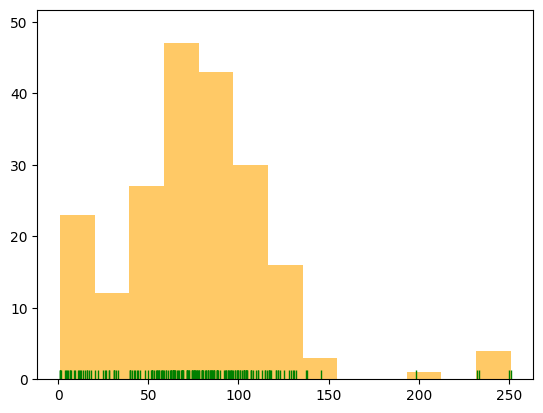

In [21]:
#sns.distplot(df_tensile_modulus_v1['property_value_median'].to_numpy()*1000,color="g")
sns.distplot(data_ty['property_value_median'].to_numpy()*1000,color='r',
                 rug=True,
                 kde=False,
                 bins=13,
                 fit=None,
                 hist_kws={'alpha':0.6,'color':'orange'},
                 rug_kws={'color':'g'},
                 norm_hist=False)

In [22]:
from rdkit import Chem
from rdkit.Chem import AllChem
def get_Morgan_fingerprint_frequency(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        info={}
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,3,nBits=2048,bitInfo=info)
        key=[key for key in info.keys()]
        frq=[len(value) for value in info.values()]
        new_info={key: value for key, value in zip(key, frq)}
        mff=[0] * len(list(fp))
        for key, value in new_info.items():
            mff[key] = value
    except:
        mff=None
    return mff

data_ty['morgan_fp_with_freq'] = data_ty['smiles'].apply(get_Morgan_fingerprint_frequency)

In [23]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,mean_absolute_percentage_error

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data_ty['morgan_fp_with_freq'].tolist(), data_ty['property_value_median'].tolist(), test_size=0.1, random_state=10)

rf = RandomForestRegressor(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

score = rf.score(X_test, y_test)
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae=mean_absolute_error(y_test, y_pred)
#mape=mean_absolute_percentage_error(y_test,y_pred)
print('MSE:', mse)
print('R2 score:', r2)
print('MAE:',mae)
#print('MAPE',mape)

MSE: 0.000391197357486477
R2 score: 0.8409751461542392
MAE: 0.012401124285714287


0.8409751461542392


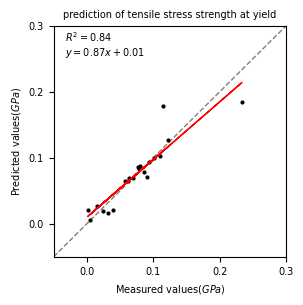

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
def R2(target, predict):
    SSE = sum((target - predict) ** 2)
    SST = sum((target - (target).mean()) ** 2)
    return 1 - (SSE / SST)

x = np.array(y_test)
y = np.array(y_pred)

fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
    # 绘制1:1对角线，linewidth线的粗细，ls线的格式，c线的颜色，
ax.plot((0, 1), (0, 1), linewidth=1, transform=ax.transAxes, ls='--', c='k', label="1:1 line", alpha=0.5)
    # 绘制点，'o'点的形状，点的颜色，markersize点的大小
ax.plot(x, y, 'o', c='black', markersize=2)
 
    # polyfit(x, y, 1)，1代表线性拟合
    # parameter返回的是线性拟合线的斜率和截距
parameter = np.polyfit(x, y, 1)
f = np.poly1d(parameter)
ax.plot(x, f(x), 'r-', lw=1)
 
    # 计算决定系数R
r2 = R2(x,y)
print(r2)
 
    # 那个框框的设置
bbox = dict(boxstyle="round", fc='1', alpha=0.)
bbox = bbox
    # 在图上安放R2和拟合曲线公式，0.05和0.87是位置偏移量，自己调试
plt.text(0.05, 0.87, "$R^2=%.2f$\n$y=%.2fx+%.2f$" % ((r2), parameter[0], parameter[1]),
             transform=ax.transAxes, size=7, bbox=bbox)
 
    # 横轴的设置
ax.set_xlabel('Measured values($GPa$)', fontsize=7)
ax.set_ylabel("Predicted values($GPa$)", fontsize=7)
 
    # 设置图片title
ax.tick_params(labelsize=7)
ax.set_title("prediction of tensile stress strength at yield", fontsize=7)
 
x_major_locator = MultipleLocator(0.1)
ax.xaxis.set_major_locator(x_major_locator)
y_major_locator = MultipleLocator(0.1)
ax.yaxis.set_major_locator(y_major_locator)
    # 坐标轴
ax.set(xlim=(-0.05, 0.3), ylim=(-0.05, 0.3))
 
    # plt.savefig("out.png", bbox_inches='tight')
plt.show()


In [30]:
# r2_list=[]
# for i in range(0,200):
#     X_train, X_test, y_train, y_test = train_test_split(data_ty['morgan_fp_with_freq'].tolist(), data_ty['property_value_median'].tolist(), test_size=0.1, random_state=i)

#     rf = RandomForestRegressor(n_estimators=100, random_state=42)

#     rf.fit(X_train, y_train)

#     score = rf.score(X_test, y_test)
#     y_pred = rf.predict(X_test)
#     mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)
#     r2_list.append(r2)

In [31]:
# np.mean(r2_list)

In [32]:
# from sklearn.model_selection import KFold
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# # 将数据划分为特征和标签
# X = data_ty['morgan_fp_with_freq'].tolist()
# y = data_ty['property_value_median'].tolist()

# # 进行五折交叉验证
# kf = KFold(n_splits=10, shuffle=True, 
# random_state=28
# )
# scores = []
# mse_list = []
# r2_list = []
# mae_list = []

# for train_index, val_index in kf.split(X):
#     #print(train_index)
#     X_train_fold, X_val_fold = [X[i] for i in train_index], [X[i] for i in val_index]
#     y_train_fold, y_val_fold = [y[i] for i in train_index], [y[i] for i in val_index]

#     # 初始化随机森林模型
#     rf_kf = RandomForestRegressor(n_estimators=100, random_state=42)

#     # 训练模型
#     rf_kf.fit(X_train_fold, y_train_fold)

#     # 在验证集上进行预测
#     y_pred_val = rf_kf.predict(X_val_fold)

#     # 计算模型评估指标
#     score = rf_kf.score(X_val_fold, y_val_fold)
#     mse = mean_squared_error(y_val_fold, y_pred_val)
#     r2 = r2_score(y_val_fold, y_pred_val)
#     mae = mean_absolute_error(y_val_fold, y_pred_val)

#     # 保存评估指标
#     scores.append(score)
#     mse_list.append(mse)
#     r2_list.append(r2)
#     mae_list.append(mae)

# # 打印五折交叉验证的评估指标
# print("Scores: ", scores)
# print("Mean MSE: ", sum(mse_list)/len(mse_list))
# print("Mean R2: ", sum(r2_list)/len(r2_list))
# print("Mean MAE: ", sum(mae_list)/len(mae_list))

Scores:  [0.6854523675881421, -0.07731841074533907, 0.5317372228696474, 0.8410867844695932, 0.3059128955203545, 0.08626498108490421, 0.6956208205488483, 0.8855644819985545, 0.8378348394153432, 0.8115400059020422]
Mean MSE:  0.0008068017283757502
Mean R2:  0.5603695988652091
Mean MAE:  0.01616692844880952


Text(0.5, 1.0, 'distribution')

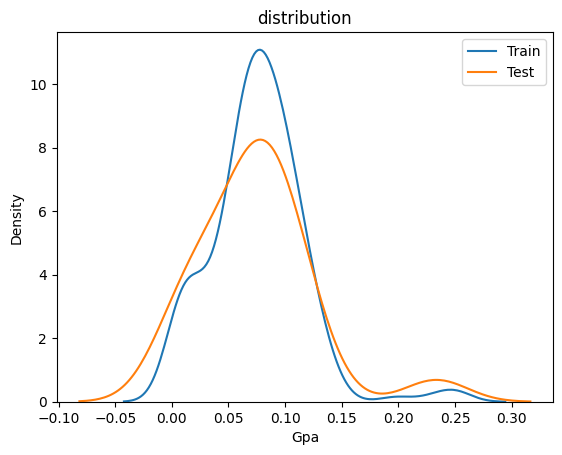

In [26]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.kdeplot(data=np.array(y_train),label='Train')
sns.kdeplot(data=np.array(y_test),label='Test')
plt.legend()
plt.xlabel('Gpa')
plt.title('distribution')

In [27]:
np.max(y_test)

0.2335

In [28]:
def get_predict_for_new_polymer(smi):
    fp=get_Morgan_fingerprint_frequency(smi)
    fp=np.array(fp)
    result=rf.predict(fp.reshape(1, -1))
    return smi,result

get_predict_for_new_polymer('*C(C(=O)OC)(C*)C')


('*C(C(=O)OC)(C*)C', array([0.01874997]))

In [29]:
class Predictor():
    def __init__(self,model):
        self.model=model

    def get_Morgan_fingerprint_frequency(self,smi):
        try:
            mol = Chem.MolFromSmiles(smi)
            info={}
            fp = AllChem.GetMorganFingerprintAsBitVect(mol,3,nBits=2048,bitInfo=info)
            key=[key for key in info.keys()]
            frq=[len(value) for value in info.values()]
            new_info={key: value for key, value in zip(key, frq)}
            mff=[0] * len(list(fp))
            for key, value in new_info.items():
                mff[key] = value
        except:
            mff=None
        return mff 
    
    def get_predict_for_new_polymer(self,smi):
        fp=self.get_Morgan_fingerprint_frequency(smi)
        fp=np.array(fp)
        result=rf.predict(fp.reshape(1, -1))
        return smi,result
    
    def get_predict_for_new_polymers(self,smi):
        fp_list=[]
        smi_list=[]
        nan_smiles=[]
        for i in smi:
            if Chem.MolFromSmiles(i):
                fp=self.get_Morgan_fingerprint_frequency(i)
                #print(fp)
                fp_list.append(fp) 
                smi_list.append(i)
            else:
                nan_smiles.append(i)
        if len(fp_list)>0:
            result=rf.predict(np.array(fp_list))
        else:
            result=-1
        return smi_list,result,nan_smiles

In [30]:
my_predictor=Predictor(rf)

In [31]:
my_predictor.get_predict_for_new_polymer('*C(C(=O)OC)(C*)C')

('*C(C(=O)OC)(C*)C', array([0.01874997]))

In [32]:
my_predictor.get_predict_for_new_polymers(['*C(C(=O)OC)(C*)C','*CCO*','*CC(F)*','*C[i](C(=O)Oc1ccc(cSc2ccc(*)cc2)c2ccccc2)cc1'])

[19:54:39] SMILES Parse Error: syntax error while parsing: *C[i](C(=O)Oc1ccc(cSc2ccc(*)cc2)c2ccccc2)cc1
[19:54:39] SMILES Parse Error: Failed parsing SMILES '*C[i](C(=O)Oc1ccc(cSc2ccc(*)cc2)c2ccccc2)cc1' for input: '*C[i](C(=O)Oc1ccc(cSc2ccc(*)cc2)c2ccccc2)cc1'


(['*C(C(=O)OC)(C*)C', '*CCO*', '*CC(F)*'],
 array([0.01874997, 0.01647163, 0.03142656]),
 ['*C[i](C(=O)Oc1ccc(cSc2ccc(*)cc2)c2ccccc2)cc1'])

In [33]:
my_predictor.get_predict_for_new_polymers(['*C[i](C(=O)Oc1ccc(cSc2ccc(*)cc2)c2ccccc2)cc1'])

[19:54:41] SMILES Parse Error: syntax error while parsing: *C[i](C(=O)Oc1ccc(cSc2ccc(*)cc2)c2ccccc2)cc1
[19:54:41] SMILES Parse Error: Failed parsing SMILES '*C[i](C(=O)Oc1ccc(cSc2ccc(*)cc2)c2ccccc2)cc1' for input: '*C[i](C(=O)Oc1ccc(cSc2ccc(*)cc2)c2ccccc2)cc1'


([], -1, ['*C[i](C(=O)Oc1ccc(cSc2ccc(*)cc2)c2ccccc2)cc1'])

In [34]:
my_predictor.get_predict_for_new_polymers(['*Oc1c(C)cc(C(*)=O)cc1C'])

(['*Oc1c(C)cc(C(*)=O)cc1C'], array([0.06237689]), [])

In [35]:
my_predictor.get_predict_for_new_polymers(['[*]Nc1ccc(Oc2ccc(C([*])=O)cc2)cc1'])

(['[*]Nc1ccc(Oc2ccc(C([*])=O)cc2)cc1'], array([0.12726311]), [])

In [36]:
my_predictor.get_predict_for_new_polymers(['*Nc1ccc(-c2ccc(C(*)=O)cc2)cc1'])

(['*Nc1ccc(-c2ccc(C(*)=O)cc2)cc1'], array([0.14187193]), [])

In [37]:
my_predictor.get_predict_for_new_polymers(['*/C=C/CC(*)c1ccccc1','*CC(*)C(=O)N(CC(=O)c1ccccc1)c1ccccc1','*CC(*)CC(=O)c1ccccc1'])

(['*/C=C/CC(*)c1ccccc1',
  '*CC(*)C(=O)N(CC(=O)c1ccccc1)c1ccccc1',
  '*CC(*)CC(=O)c1ccccc1'],
 array([0.1050535 , 0.09743345, 0.08740156]),
 [])

In [38]:
my_predictor.get_predict_for_new_polymers(['*/C=C/CC(*)c1ccccc1',
'*CC(*)C(=O)N(CC(=O)c1ccccc1)c1ccccc1',
'*CC(*)CC(=O)c1ccccc1',
'*/C=C(/*)Cc1ccccc1',
'*CC(*)C(CCc1ccccc1)c1ccccc1',
'*C=C(*)CCc1ccccc1',
'*CC(*)C(c1ccccc1)c1ccccc1',
'*Nc1ccccc1C(=O)Nc1ccccc1*'])

(['*/C=C/CC(*)c1ccccc1',
  '*CC(*)C(=O)N(CC(=O)c1ccccc1)c1ccccc1',
  '*CC(*)CC(=O)c1ccccc1',
  '*/C=C(/*)Cc1ccccc1',
  '*CC(*)C(CCc1ccccc1)c1ccccc1',
  '*C=C(*)CCc1ccccc1',
  '*CC(*)C(c1ccccc1)c1ccccc1',
  '*Nc1ccccc1C(=O)Nc1ccccc1*'],
 array([0.1050535 , 0.09743345, 0.08740156, 0.08994802, 0.09445285,
        0.08783702, 0.09269385, 0.12060039]),
 [])

In [39]:
my_predictor.get_predict_for_new_polymers(['*c1ccc(N2C(=O)c3ccc(S(=O)(=O)c4ccc5c(c4)C(=O)N(*)C5=O)cc3C2=O)cc1'])

(['*c1ccc(N2C(=O)c3ccc(S(=O)(=O)c4ccc5c(c4)C(=O)N(*)C5=O)cc3C2=O)cc1'],
 array([0.17994565]),
 [])

In [40]:
my_predictor.get_predict_for_new_polymers(['*Oc1c(C)cc(C(*)=O)cc1C'])

(['*Oc1c(C)cc(C(*)=O)cc1C'], array([0.06237689]), [])

In [41]:
def plot_hist(prediction, n_to_generate):
    #print("Mean value of predictions:", prediction.mean())
    print("Mean value of predictions:", np.mean(prediction))
    print("Proportion of valid SMILES:", len(prediction)/n_to_generate)
    ax = sns.kdeplot(prediction, shade=True)
    ax.set(xlabel='Predicted tensile strength at yield ', 
           title='Distribution of predicted yield for generated molecules')
    plt.show()

In [42]:
def estimate_and_update(generator, predictor, n_to_generate, **kwargs):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, predict_len=120)[1:-1])

    sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
    unique_smiles = list(np.unique(sanitized))[1:]
    print(unique_smiles)

    #smiles, prediction, nan_smiles = predictor.predict(unique_smiles, get_features=get_fp)  
    smiles,prediction, nan_smiles=predictor.get_predict_for_new_polymers(unique_smiles)                                                 
    plot_hist(prediction, n_to_generate)
        
    return smiles, prediction

In [43]:
import warnings

warnings.filterwarnings('ignore')

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

Generating molecules...: 100%|██████████| 1000/1000 [00:19<00:00, 51.05it/s]


['*', '**', '*/C(=C/c1ccc(*)cc1)c1ccc(N(O)CC)cc1', '*/C=C(/*)CCCCOc1ccc(OC(=O)c2cccc(C(=O)O)c2)cc1', '*/C=C(/*)CNC(=O)c1ccc(C(=O)OC)cc1', '*/C=C(/*)C[N+](C)(C)CCCC', '*/C=C(/*)Sc1ccc(/N=N/c2ccccc2)cc1', '*/C=C(/*)c1ccc(C(=O)c2ccc(C(=O)OC(CCCCCCCC)C(=O)Oc3ccccc3)cc2)cc1', '*/C=C(/*)c1cccc(C(C)CC)c1', '*/C=C(\\CC#N)S(=O)(=O)C(C)CC(*)=O', '*/C=C/C(C)(C(*)=O)c1ccc(C)cc1', '*/C=C/C(C=O)/C=C/C(=O)O*', '*/C=C/C(OC(=O)CCCCCCCCCCCCC(=O)O*)C(=O)OCC(C)C', '*/C=C/C1CCOC(*)C1', '*/C=C/C=C(*)=O', '*/C=C/C=C(/*)Cl', '*/C=C/CC(*)C(=O)OCCOCCOCCOC', '*/C=C/C[Si](*)(C)CCCCCCCCCCCCC', '*/C=C/c1cc(OCCCCCCCCC)c(*)cc1OC', '*/C=C/c1cc(OCCOCC(*)C(=O)OCCCCCC)cc(C(=O)OCC)c1', '*/C=C/c1ccc(*)c(-c2ccc(C#N)cc2)c1', '*/C=C/c1ccc(*)c(OC)c1', '*/C=C/c1ccc(/C=C/C(=*)OC(C)C)cc1', '*/C=C/c1ccc(C(=O)CCCOC(=O)c2ccc(C(=O)Oc3ccc(O*)c(C)c3)cc2C)c(C)c1', '*/C=C/c1ccc(C(CC(=*)(F)C(=O)O)C(F)(F)F)cc1', '*/C=C/c1ccc(CC(=O)c2cccc(O*)c2)cc1', '*/C=C/c1cccc(/C=C/C=C/c2ccc(*)cc2)c1', '*/C=N/c1cc(C)c(*)cc1CCCCCC', '*/C=N/c1ccc(Nc2ccc(C

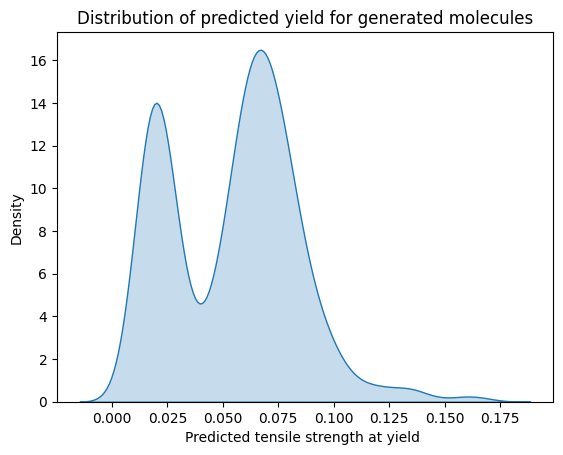

In [44]:
smiles_unbiased, prediction_unbiased = estimate_and_update(my_generator,
                                                           my_predictor,
                                                           n_to_generate=1000)

In [45]:
from reinforcement import Reinforcement

In [46]:
my_generator_max = StackAugmentedRNN(input_size=gen_data.n_characters, 
                                     hidden_size=hidden_size,
                                     output_size=gen_data.n_characters, 
                                     layer_type=layer_type,
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=stack_width, stack_depth=stack_depth, 
                                     use_cuda=use_cuda, 
                                     optimizer_instance=optimizer_instance, lr=lr)

my_generator_max.load_model('/home/cbe/AI4CHEM/polymer_design/ReLeaSE/checkpoints/generator/checkpoint_polymer_rnn_v1')

In [47]:
# Setting up some parameters for the experiment
n_to_generate = 200
n_policy_replay = 10
n_policy = 15
n_iterations = 17#100

In [48]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

In [49]:
def get_reward_max(smiles, predictor, invalid_reward=0.0, get_features=get_fp):
    #mol, prop, nan_smiles = predictor.predict([smiles], get_features=get_features)
    mol, prop, nan_smiles =predictor.get_predict_for_new_polymers([smiles])
    if len(nan_smiles) == 1:
        return invalid_reward
    return np.exp(prop[0]*10.5)

In [50]:
get_reward_max('*C[i](C(=O)Oc1ccc(cSc2ccc(*)cc2)c2ccccc2)cc1', my_predictor, invalid_reward=0.0, get_features=get_fp)

0.0

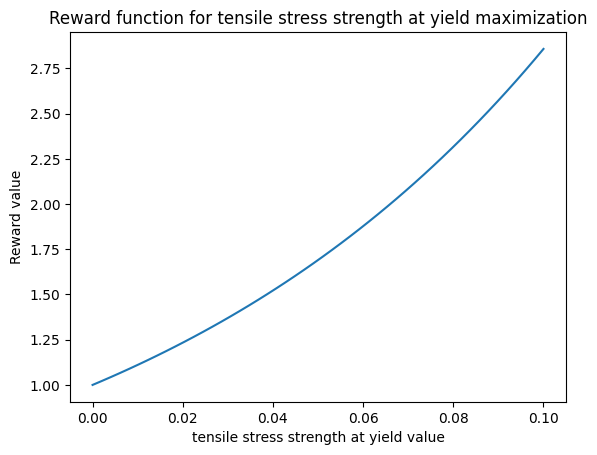

In [51]:
x = np.linspace(0, 0.1)
y = np.exp(x*10.5)
plt.plot(x, y)
plt.xlabel('tensile stress strength at yield value')
plt.ylabel('Reward value')
plt.title('Reward function for tensile stress strength at yield maximization')
plt.show()

In [52]:
RL_max = Reinforcement(my_generator_max, my_predictor, get_reward_max)

In [53]:
rewards_max = []
rl_losses_max = []

Policy gradient...: 100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


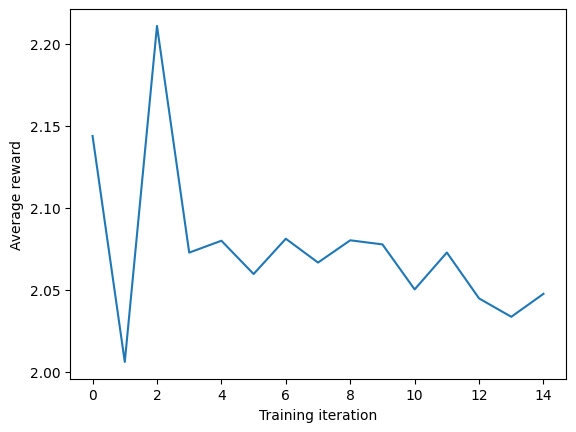

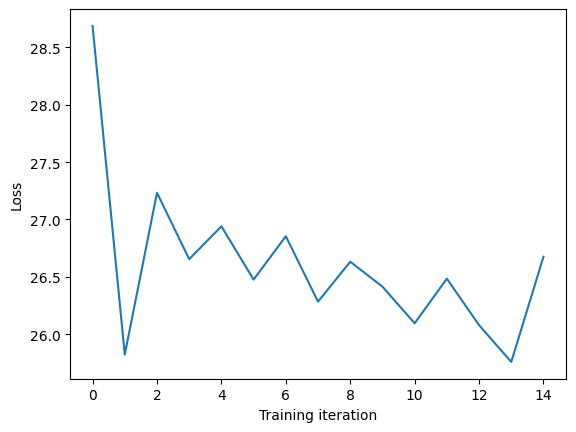

Generating molecules...: 100%|██████████| 200/200 [00:03<00:00, 52.71it/s]


['*/C=C(\\C)CCC(*)(C)C', '*/C=C/C(C)C(*)(CC(C)=O)C(=O)OCC', '*/C=C/C=Cc1cc(OCCC=C(c2ccccc2)c2ccc(/N=C/c3ccccc3)cc2)cc(*)c1C', '*/C=C/c1cc(*)c(CCCCCCCCCC)c(C(CC)CCC)c1', '*/N=N/c1ccc(C(C(=O)O)c2ccccc2)cc1*', '*C', '*C#CC#COc1ccc(/C=C/C=C/CCc2ccc(*)cc2)cc1', '*C(=C=*)CCOC(=O)SC', '*C(=N)N(CCO)C(=O)C(*)S', '*C(=O)NCCCCCCCNC(=O)Nc1cccc(NC(=O)CCCCCCCCCCCCCCCOC(*)=O)c1', '*C(=O)NNC(=O)c1cc(*)cc(*)cc1Cl', '*C(=O)c1cc(N=*)cc(Cl)c1Cl', '*C(=O)c1cc(NC(=O)C(C)N(*)C)cc(C(=O)OCCCCCCCC)c1', '*C=C(*)OCC(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F', '*C=C(C(=O)OCCCC)C(*)(O)C(O)C(=O)OCC', '*CC(*)(C#N)C(=O)OCCCCS(*)(C)CC', '*CC(*)(C)C(=O)OCCCCCCCCCOc1cc(C(=O)Oc2ccc(OC)cc2)ccc1-c1ccccc1', '*CC(*)(C)C(=O)OCCCCCCCOc1ccc(C(=O)Oc2ccc(/N=N/c3ccc(C)cc3)cc2)cc1', '*CC(*)(C)C(=O)OCCCCOc1ccc(C(=O)Oc2ccc(-c3ccc(C(C)C)cc3)cc2)cc1', '*CC(*)(C)C(=O)OCc1ccc(C)c(OC)c1', '*CC(*)(C)C(=O)Oc1ccc(-c2ccc(C(=O)Oc3ccccc3C(=O)O)cc2)c(OCCCCCCCC)c1', '*CC(*)(CC(=O)OCCOCCOC(=O)c1ccccc1/C=C/c1ccc(O)cc1)c1ccc(c2ccccc2)cc1', '*CC(*)(CC(=O)OCS(=O

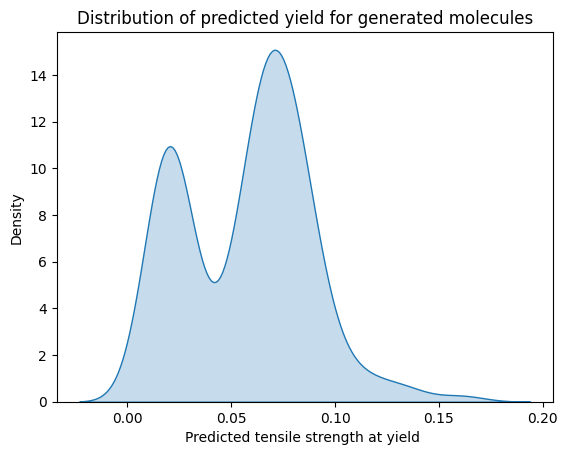

Sample trajectories:
*/C=C(\C)CCC(*)(C)C
*/C=C/C(C)C(*)(CC(C)=O)C(=O)OCC
*/C=C/C=Cc1cc(OCCC=C(c2ccccc2)c2ccc(/N=C/c3ccccc3)cc2)cc(*)c1C
*/C=C/c1cc(*)c(CCCCCCCCCC)c(C(CC)CCC)c1
*/N=N/c1ccc(C(C(=O)O)c2ccccc2)cc1*


Policy gradient...: 100%|██████████| 15/15 [00:10<00:00,  1.36it/s]


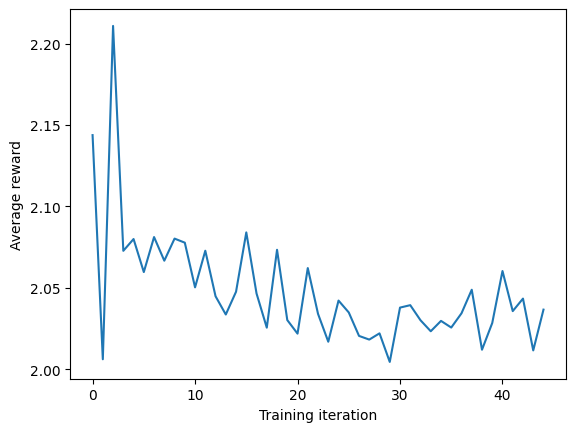

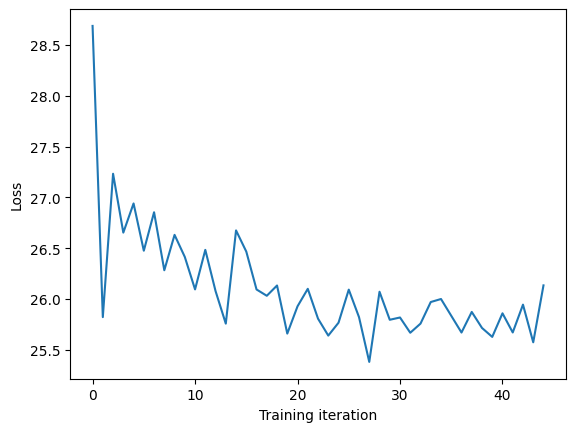

Generating molecules...: 100%|██████████| 200/200 [00:03<00:00, 55.98it/s]


['*/C([2H])=C(/*)c1ccc(/N=N/c2ccccc2)cc1', '*/C=C(/*)COc1ccc(/N=N/c2ccc(OC)cc2)cc1', '*/C=C(/*)c1ccc(C)c(OCC)c1', '*/C=C(/*)c1ccc(OC)cc1', '*/C=C(/*)c1ccccc1OC', '*/C=C/C(=O)OCCCCCOc1ccc(-c2ccc(OC(=O)c3ccc(O*)cc3)cc2)cc1', '*/C=C/C1C=C(*)CC1', '*/C=C/CCCCCCCCCCCCCCCC[Si](*)(C)c1ccc(C#N)cc1', '*/C=C/c1cc(OCCCCCCCCCCCC)c(*)cc1OCCC', '*/C=C/c1ccc(/C=C/C=C/CC(=O)Oc2ccc(C(=O)Oc3ccc(-c4ccc(*)cc4)cc3)cc2)cc1', '*/C=C/c1ccc(Oc2ccc(OC(*)=O)cc2)cc1', '*C(*)=N', '*C(=O)CCCC(=O)NN1CCN(C(*)=O)CC1', '*C(=O)NCCCCCC[Si](C)(CCC)/N=C(/*)C', '*C(=O)Nc1ccccc1C(=O)Nc1cccc(*)c1', '*C(C)=C(*)OC(=O)c1ccc(OCC)cc1', '*C1=CC(C/C=C/C(*)C([2H])=C)C1', '*C=C(Nc1ccc(*)cc1)OC(=O)Nc1ccccc1', '*C=Cc1ccc(*)c(Br)c1', '*CC(*)(C)C(=O)OCCCCCCCCCCOc1ccc(C(=O)Oc2ccc(OC)cc2)cc1', '*CC(*)(C)C(=O)OCCCCCCOc1ccc(C(=O)c2ccc(OC)cc2)cc1', '*CC(*)(C)C(=O)OCCCCCOc1ccc(/C=C/c2ccc(OCC(C)CCCCCCOCCOCCOc3ccccc3)cc2)cc1', '*CC(*)(C)C(=O)OCCCCO#Cc1cc(CC)c(C#N)c(C(=O)O)c(OC)c1', '*CC(*)(C)C(=O)OCCCCOc1ccc(/C=C/c2ccc(/C=C/c3ccc([N+](=O)[O-])cc3

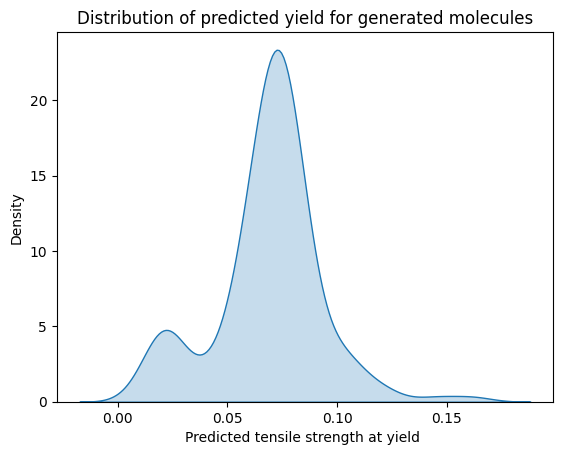

Sample trajectories:
*/C([2H])=C(/*)c1ccc(/N=N/c2ccccc2)cc1
*/C=C(/*)COc1ccc(/N=N/c2ccc(OC)cc2)cc1
*/C=C(/*)c1ccc(C)c(OCC)c1
*/C=C(/*)c1ccc(OC)cc1
*/C=C(/*)c1ccccc1OC


Policy gradient...: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


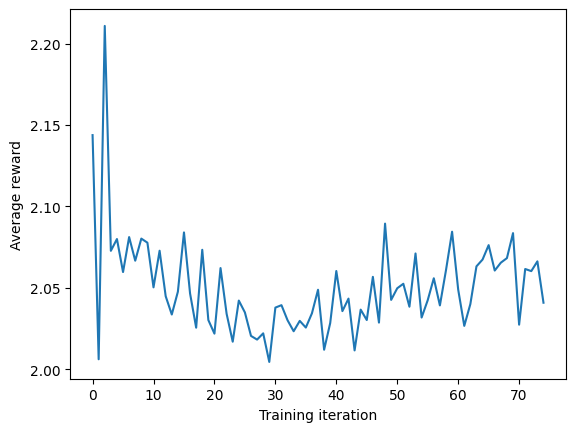

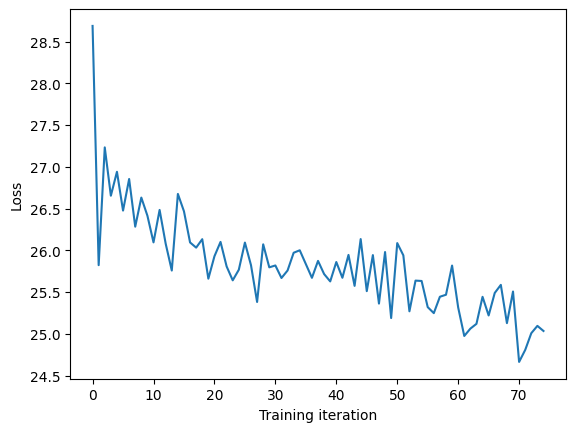

Generating molecules...: 100%|██████████| 200/200 [00:03<00:00, 60.83it/s]


['*', '*/C=C/C1CC(*)C(C#N)C1', '*/C=C/C=C/C=C/CCCOC(=O)C(C)CCCCOc1ccc(*)cc1', '*/C=C/CCCCCCOC(=O)c1ccc(C(C)(C)c2ccc(C(=O)O*)cc2)cc1', '*/C=C/c1cc(OCCC(C)NC(=O)c2ccccc2)ccc1OC(=O)c1ccccc1-c1ccccc1C(=O)OC(=O)c1cccc(C(*)=O)c1', '*/C=N/c1ccc(Cc2ccc(C*)cc2)cc1', '*/N=C(/*)c1ccc(F)cc1', '*/N=N/c1ccc(Sc2ccc(N=*)cc2)cc1', '*C', '*C(*C/C=C/CSC(=O)OC)OC', '*C(/C=C/C(C=C)CBr)[SH](*)=O', '*C(=O)CCCCCCCCCCNC(=O)c1ccccc1C(=O)NCCCCCCNC(=O)C(*)C', '*C(=O)COC(=O)c1ccccc1C(=O)Nc1ccccc1Cc1ccccc1NC(*)=O', '*C(=O)NCCNC(=O)OCCCCCCOC(=O)Oc1ccc(Oc2ccccc2)cc1*', '*C(=O)Nc1cc(C)c(C(=O)OC(=O)c2cccc(*)c2)cc1C', '*C(=O)c1ccc(NC(=O)Nc2ccc(C(O)c3ccc(*)cc3)cc2)cc1', '*C(=O)c1cccc(CS(=O)(=O)c2ccc(NC(=O)C(C)CCC(=O)NOC(=O)c3ccc(*)cc3)c2)cc1', '*C(=O)c1ccccc1C(=O)OC(=O)c1ccccc1N(*)c1ccccc1', '*C(=O)c1ccccc1S(*)(=O)=O', '*C=C(C#CCOC(=O)C(C)C)C(=O)O*', '*CC', '*CC#CCOc1ccc(-c2ccc(OCCCCCCOc3ccc(C(*)=O)cc3)cc2)cc1', '*CC(*)(C)C(=O)OC(=O)OC', '*CC(*)(C)C(=O)OCCCCCCCCCCCC(=O)N(C)c1ccc1', '*CC(*)(C)C(=O)OCCCCCCCCCCCCCCCCCCCCCCC

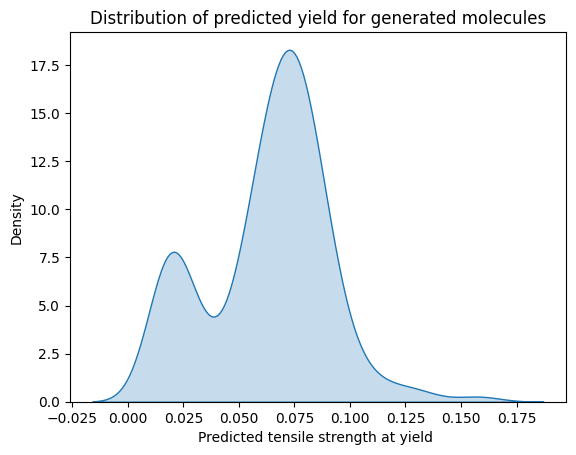

Sample trajectories:
*
*/C=C/C1CC(*)C(C#N)C1
*/C=C/C=C/C=C/CCCOC(=O)C(C)CCCCOc1ccc(*)cc1
*/C=C/CCCCCCOC(=O)c1ccc(C(C)(C)c2ccc(C(=O)O*)cc2)cc1
*/C=C/c1cc(OCCC(C)NC(=O)c2ccccc2)ccc1OC(=O)c1ccccc1-c1ccccc1C(=O)OC(=O)c1cccc(C(*)=O)c1


Policy gradient...: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


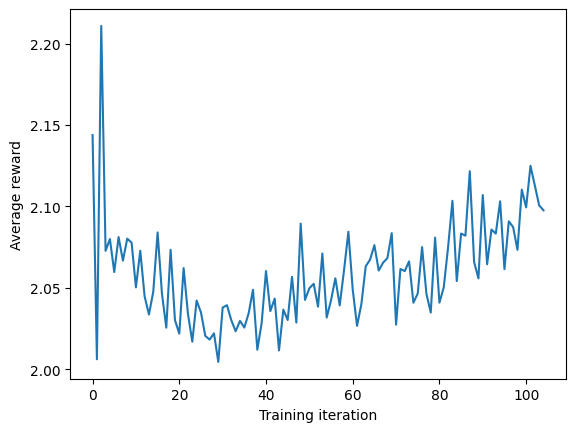

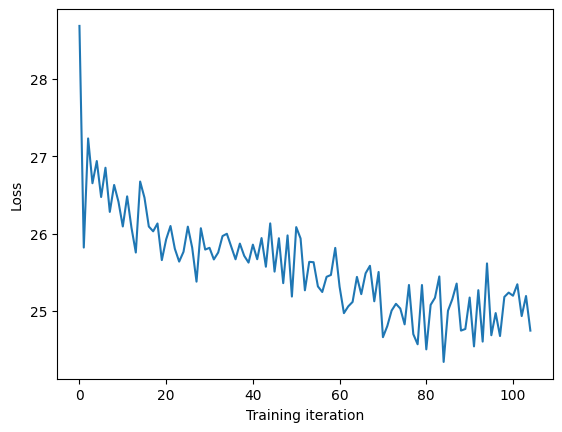

Generating molecules...: 100%|██████████| 200/200 [00:03<00:00, 58.58it/s]


['*#N', '*/C=C(/*)c1ccc(C(C)(C)C)cc1', '*/C=C/C(C#N)=C(/C)NSC(*)=O', '*/C=C/C(C)=C/C(=sNc1ccccc1)C(*)OCCOc1ccc(C(=O)O[Na])cc1', '*/C=C/CCC/C=C(/*)CCCOc1ccc(/N=N/c2ccc(OC)cc2)cc1', '*/C=C/c1cc(CCCCCC)cc(*)c1OCC', '*/C=C\\c1ccc(/N=N/c2ccc(/C=C/*)cc2)cc1', '*/N=C/C=C/c1ccc(NC(=O)NN*)cc1', '*/[N+]=C/c1ccc(C(=O)c2ccc(Cc3ccc(C(*)=O)cc3)cc2)cc1', '*=Cc1ccc(N(C)Cc2cccc(N#*)c2)cc1', '*C#Cc1ccc(OCCCCCOc2ccc(C(=O)OC(=O)c3ccc(*)cc3)cc2)cc1', '*C(=O)COC(=O)c1ccccc1', '*C(=O)Nc1ccc(*)c(C)c1', '*C(=O)Nc1ccc(Cc2ccc(NC(=*)CC)cc2)cc1', '*C(=O)Nc1cccc(OCCOc2ccccc2C(=O)Oc2ccccc2Oc2cccc(*)c2)c1', '*C(=O)OCCCCCCCN(*)C(=O)c1ccccc1', '*C(=O)Oc1ccc(C(C)(C)c2ccc(Oc3ccc(*)cc3)cc2)cc1', '*C(=O)c1cc(C(*)C)ccc1=O', '*C(=O)c1ccc(C(=O)Nc2ccc(S(=O)(=O)c3ccc(*)c(S(=O)(=O)O)c3)cc2)cc1', '*C(=O)c1ccc(C(C)(C)c2ccc(*)cc2)cc1', '*C(=O)c1ccc(C)c(NC(=O)c2ccc(*)cc2)c1', '*C/C=C/CC/C=C/C', '*C=C(*)OCCOc1ccc(c2ccccc2)cc1', '*C=C(*)c1ccccc1', '*CC(*)(C#C)Cc1ccccc1', '*CC(*)(C)C(=O)OCCCCCCOc1ccc(C(=O)OC(C)COC(=O)c2ccccc2)cc1', '*C

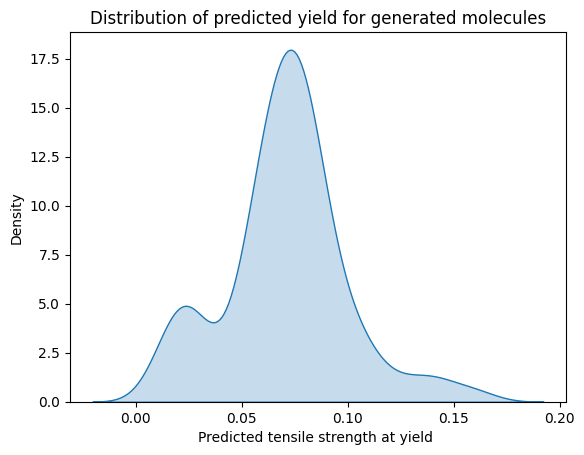

Sample trajectories:
*#N
*/C=C(/*)c1ccc(C(C)(C)C)cc1
*/C=C/C(C#N)=C(/C)NSC(*)=O
*/C=C/CCC/C=C(/*)CCCOc1ccc(/N=N/c2ccc(OC)cc2)cc1
*/C=C/c1cc(CCCCCC)cc(*)c1OCC


Policy gradient...: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


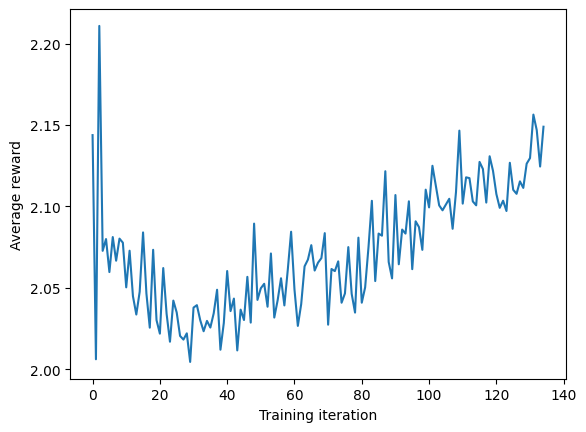

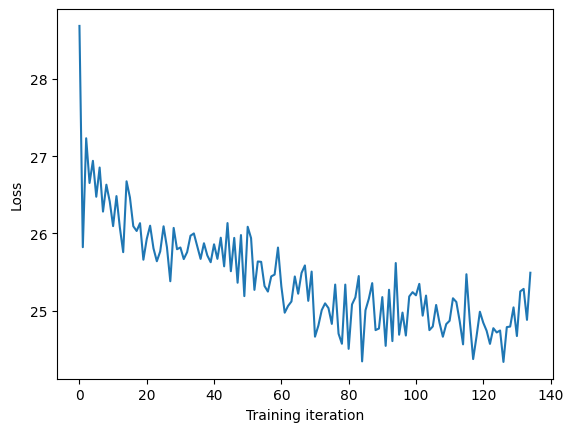

Generating molecules...: 100%|██████████| 200/200 [00:03<00:00, 56.34it/s]


['*/C(C)=N/c1ccc(COc2ccc(S(*)(=O)=O)cc2)cc1', '*/C=C(/*)Cc1ccccc1C', '*/C=C(/*)c1ccc(S(=O)(=O)O)cc1C', '*/C=C(/*)c1ccccc1C(=O)Oc1ccc(OCC)cc1', '*/C=C(\\CSC)SN(*)[Si]', '*C(*)C(=O)OCCOCCOc1ccc(/C=N/c2ccccc2)cc1', '*C(=O)Nc1ccccc1S(=O)(=O)c1ccccc1*', '*C(=O)Oc1ccc(Oc2ccc(C(*)=O)cc2)cc1', '*C(=O)c1ccc(*)cc1C(=O)O', '*C(=O)c1ccc(C(=O)Oc2ccc(OC(=O)c3ccccc3C(*)=O)cc2)cc1', '*C(=O)c1ccc(Nc2ccc(NC(=O)N(CCC)c3ccc(*)cc3)cc2)cc1', '*C(=O)c1ccc(Oc2ccc(C(=O)Nc3ccc(Oc4ccc(C)cc4)c(*)c3)cc2)cc1', '*C(=O)c1cccc(NC(=O)CCCCC(=O)N(*)C)c1', '*C(=O)c1ccccc1C(*)=S', '*C(=O)c1ccccc1C(=O)N(C)C(=*)COc1ccc(-c2ccc(PC)cc2)cc1', '*CBCCCCCCCCCCCCCCCc1ccc(*)cc1', '*CC(*)(*)C(=O)Oc1ccc(C(=O)Oc2ccc(OCCCC)cc2)cc1', '*CC(*)(C#N)C(=O)OCCCOc1ccc(/N=N/c2ccccc2)cc1', '*CC(*)(C)C(=O)NCCCOc1ccc(-c2ccc(NC(=O)c3ccccc3)cc2)cc1', '*CC(*)(C)C(=O)OCCCCCCCCCCO', '*CC(*)(C)C(=O)OCCCCCCOc1ccc(C(=O)Oc2ccc(C#N)cc2)cc1', '*CC(*)(C)C(=O)OCCCCOc1ccc(OC(=O)c2ccc(OCC)cc2)cc1', '*CC(*)(C)C(=O)OCCOCCOCCOCCOc1ccc(/C=N/c2ccccc2)cc1', '*CC(*)(C)C(

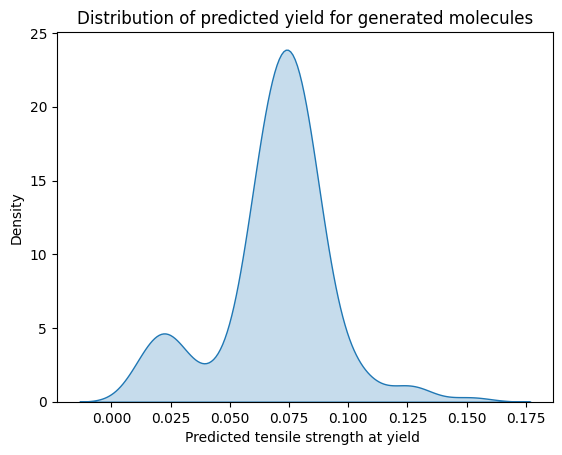

Sample trajectories:
*/C(C)=N/c1ccc(COc2ccc(S(*)(=O)=O)cc2)cc1
*/C=C(/*)Cc1ccccc1C
*/C=C(/*)c1ccc(S(=O)(=O)O)cc1C
*/C=C(/*)c1ccccc1C(=O)Oc1ccc(OCC)cc1
*/C=C(\CSC)SN(*)[Si]


Policy gradient...: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


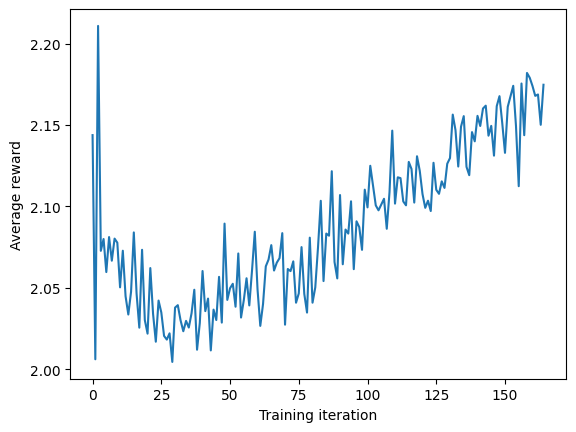

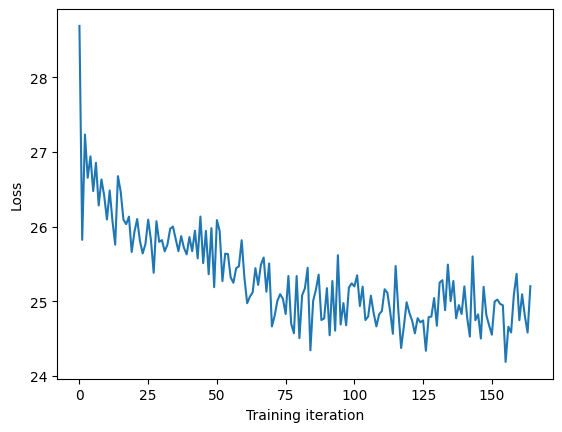

Generating molecules...: 100%|██████████| 200/200 [00:03<00:00, 51.12it/s]


['*', '*/C(=C/c1ccccc1)c1ccc(/N=C/c2ccc(*)cc2)cc1', '*/C(C#N)=C/c1ccc(OCCOCC(=O)OCCCCC(=O)Oc2ccccc2)[Si](*)(c2ccccc2)cc1O', '*/C=C/CCC(=O)CCCCCCCCCCCCCCC(=O)N(*)c1ccccc1', '*/C=C/c1ccc(C(=O)OCCCCCCNC(*)=O)cc1', '*/C=C/c1ccc(N(*)c2ccc([N+](=O)[O-])cc2)cc1', '*/C=C/c1ccccc1CO*', '*/C=C/c1ccccc1COC(=O)c1ccccc1NC(=O)c1ccccc1O*', '*/C=C/c1cccnc1C(=O)Oc1ccc(C(C)(C)c2ccc(O*)cc2)cc1', '*/N=C/c1ccc(C(=O)OC)cc1*', '*C', '*C(=*)CCCCCCCCCCCCCCOc1ccccc1', '*C(=O)C(*)c1ccccc1Cl', '*C(=O)CCCC(=O)Nc1ccc(C(=O)NCCCCNC(=O)c2ccc(C(*)=O)cc2)cc1', '*C(=O)CCCCCCNC(=O)Nc1cccc(OCCOC(*)=O)c1', '*C(=O)NCCCNC(=O)c1cccc(C(=O)Nc2ccccc2C(*)=O)c1', '*C(=O)c1ccccc1C(=O)OCCOCCOC(=O)c1ccccc1-c1ccccc1C(=O)c1ccccc1*', '*C(=O)c1ccccc1COC(=O)c1ccccc1C(=O)Nc1ccccc1C(*)=O', '*CC(*)(C#N)C(=O)OCCCCCCCCCCCCCCOc1ccc(/C=C/c2ccc(OCCCCCCCC)cc2)cc1', '*CC(*)(C)=C(Oc1ccc(Cl)cc1)S(=O)(=O)c1ccccc1', '*CC(*)(C)C(=O)OCC(=O)OCCOC(=O)c1ccccc1', '*CC(*)(C)C(=O)OCCCCCCOc1ccc(-c2ccc(S(=O)(=O)c3ccccc3)cc2)cc1', '*CC(*)(C)C(=O)OCCCN(C)Cc1ccccc1'

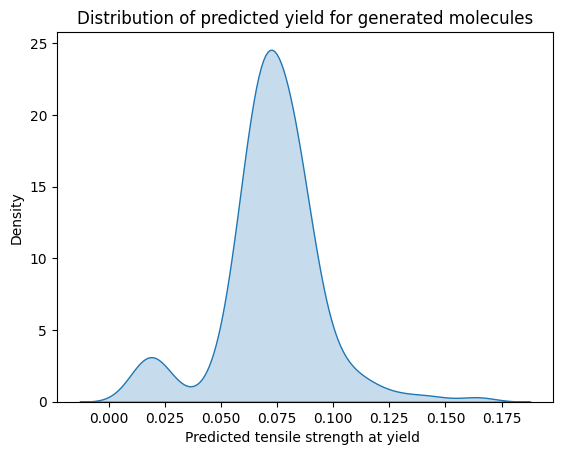

Sample trajectories:
*
*/C(=C/c1ccccc1)c1ccc(/N=C/c2ccc(*)cc2)cc1
*/C(C#N)=C/c1ccc(OCCOCC(=O)OCCCCC(=O)Oc2ccccc2)[Si](*)(c2ccccc2)cc1O
*/C=C/CCC(=O)CCCCCCCCCCCCCCC(=O)N(*)c1ccccc1
*/C=C/c1ccc(C(=O)OCCCCCCNC(*)=O)cc1


Policy gradient...: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


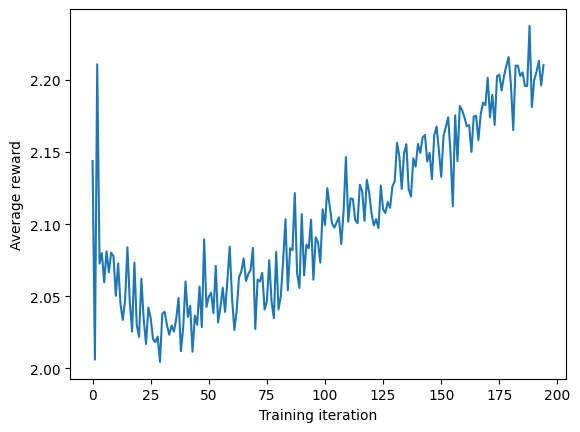

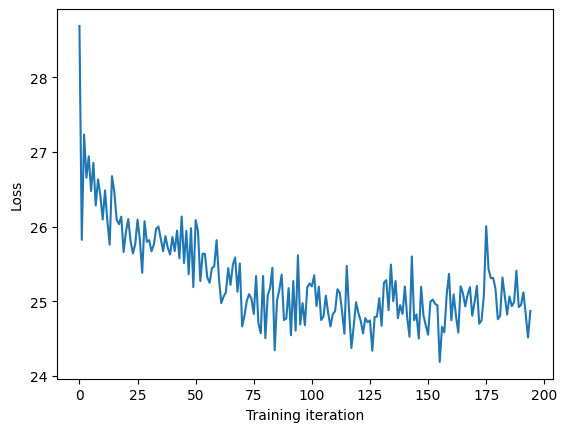

Generating molecules...: 100%|██████████| 200/200 [00:03<00:00, 51.37it/s]


['*', '**', '*/C=C/CC(*)C(=O)Oc1ccccc1', '*/C=C/c1ccccc1-c1ccccc1C(*)=O', '*/N=N/c1ccccc1CCC(=*)CCCC', '*C#CCOc1ccccc1NC(=O)c1ccccc1C', '*C(=O)c1ccc(C(=O)OC(=O)c2ccc(-c3ccccc3C(*)=O)cc2)cc1', '*C(=O)c1cccc(C(=O)NCCCCCNC(=O)c2ccccc2)c1*', '*C(=O)c1ccccc1C(=O)OCCCCCCCCCOc1ccc(OC(=O)c2ccccc2)cc1*', '*C(=O)c1ccccc1C(=O)OCCN(*)c1ccccc1*', '*C(=O)c1ccccc1C(=O)OCc1ccccc1C(=O)Nc1ccc(Cc2ccc(*)cc2)cc1', '*C(=O)c1ccccc1C(=O)Oc1ccc(*)cc1', '*C(=O)c1ccccc1C(=O)Oc1ccccc1OC(=O)c1ccccc1', '*C(=O)c1ccccc1CCOc1ccccc1C(=O)Nc1ccccc1Nc1cccc(NC(=O)NCCc2ccccc2)c1*', '*C=CC(C=CC=*)C(c1ccccc1)c1ccccc1', '*CC#CCCCCCCCCCCCCOCCCO*', '*CC(*)(C#N)C(=O)Nc1ccccc1', '*CC(*)(C)C(=O)NCCCCCCCCCCCCOc1ccc(-c2ccccc2)cc1', '*CC(*)(C)C(=O)OC(=O)c1ccccc1', '*CC(*)(C)C(=O)OCCCCCCCCOC(=O)c1ccccc1C', '*CC(*)(C)C(=O)OCCCCCCOc1ccc(-c2ccc(N(C)CC)cc2)cc1', '*CC(*)(C)C(=O)OCCCCCCOc1ccc(-c2ccccc2C[N+](C)(C)C)cc1', '*CC(*)(C)C(=O)OCCCOc1ccc(/C=C/c2ccc(C(C)CCCC)cc2)cc1', '*CC(*)(C)C(=O)OCc1ccccc1C', '*CC(*)(C)C(=O)Oc1ccccc1COc1ccccc1', '

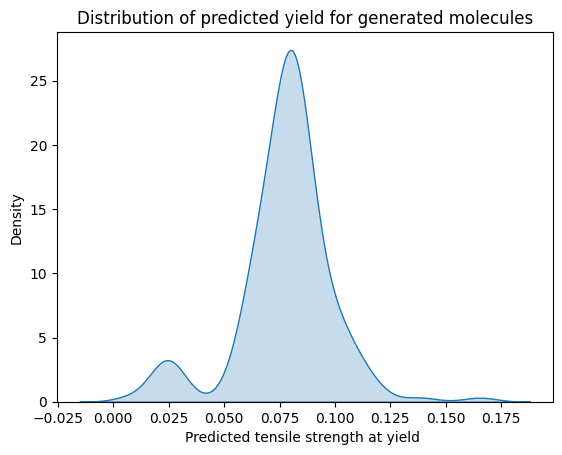

Sample trajectories:
*
**
*/C=C/CC(*)C(=O)Oc1ccccc1
*/C=C/c1ccccc1-c1ccccc1C(*)=O
*/N=N/c1ccccc1CCC(=*)CCCC


Policy gradient...: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


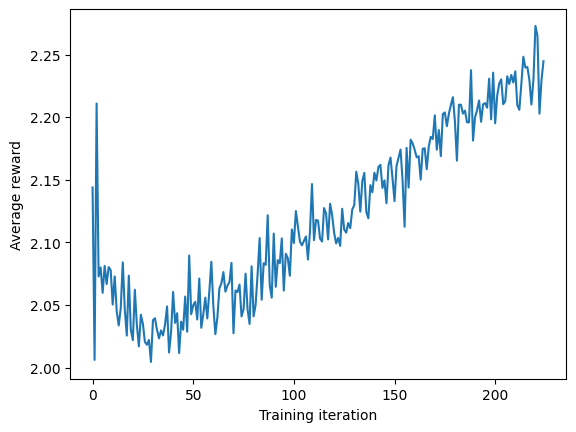

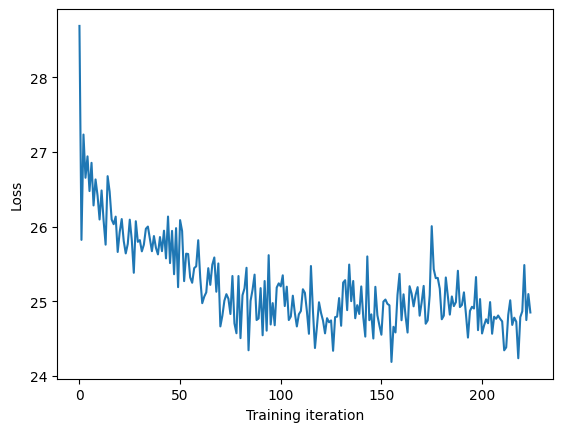

Generating molecules...: 100%|██████████| 200/200 [00:03<00:00, 54.68it/s]


['*', '*/C=C(/*)NC', '*/C=C(/*)Oc1ccc(C#N)cc1', '*/C=C(/*)c1ccc(/N=N/c2ccccc2)cc1', '*/C=C(/*)c1ccccc1[N+](=O)[Si](C)(C)C', '*/C=C(\\C)C(=O)CCCCOC(=O)CCc1ccc(C)c(NC(=O)O*)c1', '*/C=C/C(C)C(*)C(=O)OCCCCCC', '*/C=C/C=C(*)/C=C/c1ccccc1', '*/C=C/c1ccc(C(=O)NCCSC(*)=O)cc1', '*/C=C/c1ccccc1CCCCSc1ccc(*)cc1', '*/C=C/c1ccccc1COC(=O)c1ccccc1C(=O)Oc1cccc(C(=O)OCCCCCCOc2ccccc2C(=O)O*)c1', '*C(=O)C/C=C/c1ccccc1C(=O)Nc1ccccc1NC(=O)c1ccccc1C(=O)Nc1ccccc1CC(*)=O', '*C(=O)CCC/C=C(/*)c1cc(c2ccccc2)ccc1C', '*C(=O)CCCCCC(*)c1ccccc1', '*C(=O)Nc1ccc(OCCCCCCCCNC(=O)c2ccc(*)cc2)cc1', '*C(=O)c1cc(OCCCC)cc(C(*)=O)c1', '*C(=O)c1ccc(OC)c(*)c1', '*C(=O)c1ccccc1-c1ccccc1C(=O)Oc1ccccc1C(=Nc1ccccc1*)=O[4H]', '*C(C(=O)OCC)c1ccc(OC(=O)c2ccccc2S(*)(=O)=O)cc1', '*CC(*)(C)C(=O)NC(=O)C(C)C(C)C', '*CC(*)(C)C(=O)OCC(=O)NCCCN', '*CC(*)(C)C(=O)OCCCCCCCCOc1ccccc1C(=O)Nc1ccccc1', '*CC(*)(C)C(=O)OCCCCCCCCOc1ccccc1C(=O)c1ccccc1C', '*CC(*)(C)C(=O)OCCO', '*CC(*)(CC(=O)Oc1ccccc1)Oc1ccccc1', '*CC(*)C(=O)N(OC(C)CCCC)C(=O)OCc1ccccc1', 

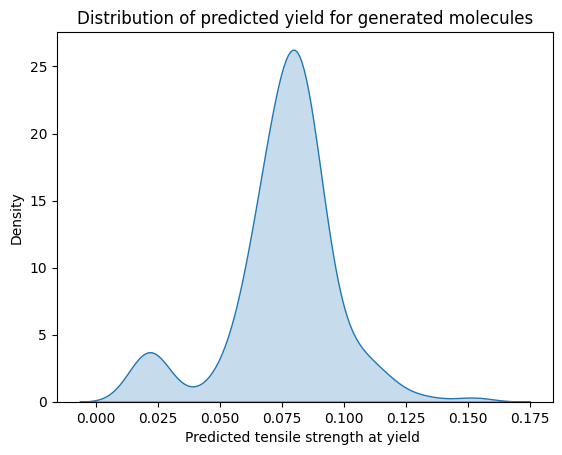

Sample trajectories:
*
*/C=C(/*)NC
*/C=C(/*)Oc1ccc(C#N)cc1
*/C=C(/*)c1ccc(/N=N/c2ccccc2)cc1
*/C=C(/*)c1ccccc1[N+](=O)[Si](C)(C)C


Policy gradient...: 100%|██████████| 15/15 [00:09<00:00,  1.63it/s]


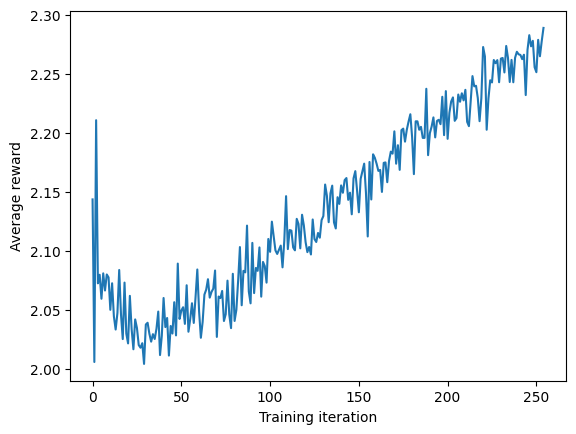

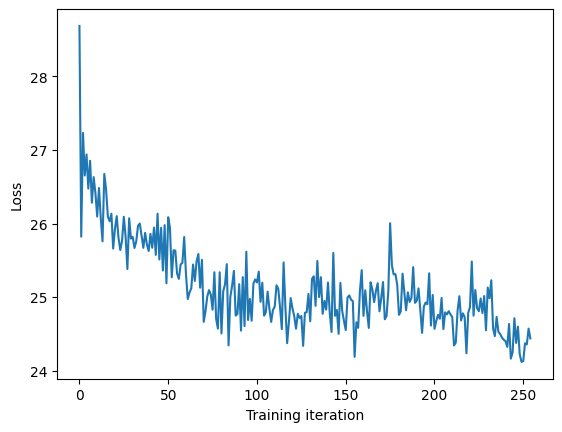

Generating molecules...: 100%|██████████| 200/200 [00:03<00:00, 63.40it/s]


['**', '*/C=C/c1ccc(/C(C)=C/c2ccc(N=*)cc2)cc1', '*/C=C/c1ccccc1NC(=O)c1ccccc1CN(*)C', '*C#Cc1ccc(C(=O)NCCCNC(=O)c2ccc(C(*)=O)cc2)cc1', '*C(*)C(=O)Oc1ccccc1', '*C(*)c1ccccc1OCCOc1ccccc1', '*C(=O)CCCCCCCCCCC(*)=O', '*C(=O)NCCNC(=O)Nc1ccc(NC(=O)c2ccc(*)cc2)cc1', '*C(=O)NNC(=O)NCCCNC(=O)Nc1ccc(NC(*)=O)c(C)c1', '*C(=O)Nc1ccc(NC(=O)CCCCCCCCCCC(=O)Nc2ccc(NC(=O)c3ccc(*)cc3)cc2)cc1', '*C(=O)Nc1ccc(Sc2ccc(Cc3ccccc3C(*)=O)cc2)cc1', '*C(=O)Nc1cccc(NC(=O)c2ccccc2C(*)=O)c1', '*C(=O)Nc1ccccc1NC(=O)c1ccccc1C(*)=O', '*C(=O)OCCCCCCOc1ccc(C(=O)c2ccc(*)cc2)cc1C(C)C', '*C(=O)c1ccccc1*', '*C(=O)c1ccccc1/C=C/c1ccccc1=CC=C(*)c1ccccc1', '*C(=O)c1ccccc1C(*)OCC', '*C(=O)c1ccccc1C(=O)NCC(=O)Nc1ccc(*)cc1', '*C(=O)c1ccccc1C(=O)NCCN(*)Cc1ccccc1', '*C(=O)c1ccccc1C(=O)Nc1ccc(S(=O)(=O)c2ccc(Sc3ccc(*)cc3)cc2)cc1', '*C(=O)c1ccccc1Cc1ccccc1C=*', '*C(C(=O)Oc1ccccc1)c1ccccc1C(=O)Nc1ccccc1NC(=O)O(*)C', '*C(C(=O)[Si](F)(F)C(F)(F)C(F)(F)C(F)(F)F)c1ccccc1C(=O)NCc1ccccc1[N+](*)Cc1ccccc1', '*C(C)*C(=O)CCCCC(=O)OC', '*C(c1ccccc1)c

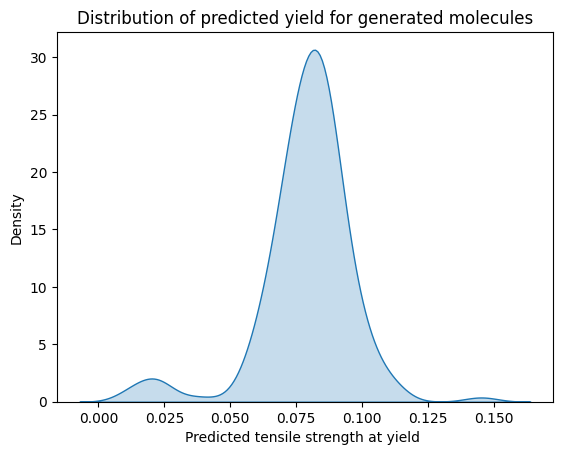

Sample trajectories:
**
*/C=C/c1ccc(/C(C)=C/c2ccc(N=*)cc2)cc1
*/C=C/c1ccccc1NC(=O)c1ccccc1CN(*)C
*C#Cc1ccc(C(=O)NCCCNC(=O)c2ccc(C(*)=O)cc2)cc1
*C(*)C(=O)Oc1ccccc1


In [54]:
for i in range(n_iterations):
    for j in trange(n_policy, desc='Policy gradient...'):
        cur_reward, cur_loss = RL_max.policy_gradient(gen_data, get_features=get_fp)
        rewards_max.append(simple_moving_average(rewards_max, cur_reward)) 
        rl_losses_max.append(simple_moving_average(rl_losses_max, cur_loss))
    
    if i % 2 == 0:
        plt.plot(rewards_max)
        plt.xlabel('Training iteration')
        plt.ylabel('Average reward')
        plt.show()
        plt.plot(rl_losses_max)
        plt.xlabel('Training iteration')
        plt.ylabel('Loss')
        plt.show()
        
        smiles_cur, prediction_cur = estimate_and_update(RL_max.generator, 
                                                        my_predictor, 
                                                        n_to_generate
                                                    )
        
        print('Sample trajectories:')
        for sm in smiles_cur[:5]:
            print(sm)

Generating molecules...:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating molecules...: 100%|██████████| 10000/10000 [02:39<00:00, 62.57it/s]


['*', '*#N', '**', '**([2H])CF', '**C(=O)Oc1ccccc1C(=O)Oc1ccccc1', '**Cc1ccccc1', '**OC(=O)c1ccccc1', '*/C(=C(/C=C/c1ccc(*)cc1)c1ccccc1)c1ccccc1', '*/C(=C/C(=O)NCc1ccccc1NC(=O)c1ccccc1*)C(=O)NCc1ccccc1C', '*/C(=C/c1ccc(/C=C/Cc2ccccc2*)cc1)CCC/C=C/c1ccccc1', '*/C(=C/c1ccccc1)C(*)c1ccccc1', '*/C(=C/c1ccccc1)c1ccccc1Sc1ccc(*)cc1', '*/C(=C\\c1ccccc1)C(*)c1ccccc1', '*/C(=N/*c1ccccc1)Oc1ccccc1', '*/C(=N/c1ccccc1)C(*)c1ccccc1', '*/C(=N/c1ccccc1)c1ccccc1*', '*/C(=N\\c1ccc(OCCOC(*)(OC)C(*)Cl)cc1)c1ccccc1', '*/C(C#N)=C(/*)c1ccccc1O', '*/C(C#N)=C(\\c1ccccc1)c1ccccc1CC(*)O', '*/C(C#N)=C/c1ccccc1C(*)O', '*/C(C)=C(/*)C#N', '*/C(C)=C(/*)c1ccccc1', '*/C(C)=C(\\C)Oc1ccc(C(=O)CN(*)CC)cc1', '*/C(C)=N/c1ccc(C(=O)Oc2ccc(*)cc2)cc1', '*/C(Cl)=C(/*)CCCOc1ccc(-c2ccccc2)cc1', '*/C=C(/*)C', '*/C=C(/*)C(=O)Oc1ccccc1', '*/C=C(/*)C(CC)C(=O)Oc1ccccc1', '*/C=C(/*)C(OC)OCCOc1ccccc1', '*/C=C(/*)C(c1ccccc1)c1ccccc1', '*/C=C(/*)CC(=O)Oc1ccccc1', '*/C=C(/*)CCCc1cc(F)c(F)c(F)c1F', '*/C=C(/*)CCN(CC)c1ccccc1', '*/C=C(/*)CCc1

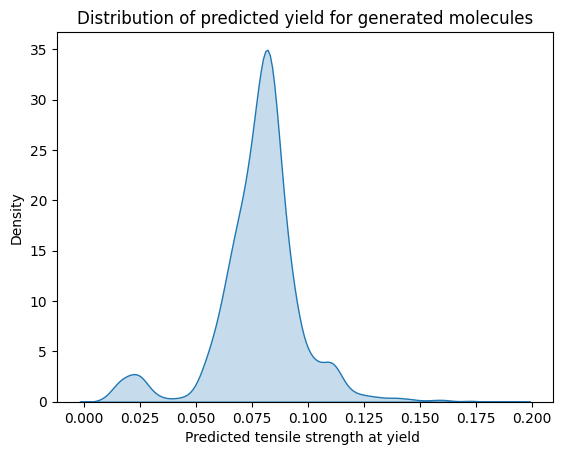

In [55]:
smiles_biased_max, prediction_biased_max = estimate_and_update(RL_max.generator, 
                                                           my_predictor,
                                                           n_to_generate=10000)

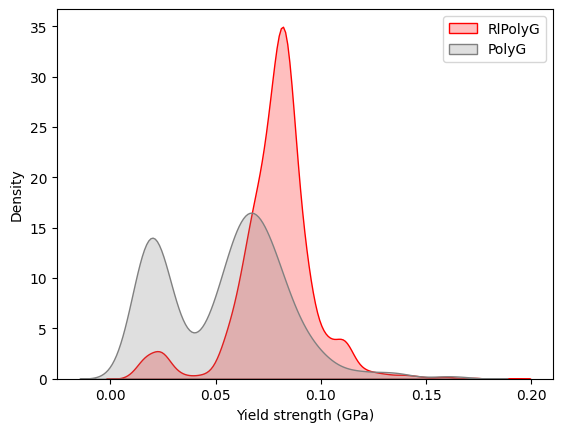

In [56]:
sns.kdeplot(prediction_biased_max,label='RlPolyG', shade=True, color='red')
sns.kdeplot(prediction_unbiased, label='PolyG', shade=True, color='grey')
plt.xlabel('Yield strength (GPa)')
plt.legend()
plt.show()

In [58]:
import pandas as pd
df_generate = pd.DataFrame({'SMILES': smiles_biased_max, 'Tensile stress strength at yield': prediction_biased_max})
df_generate 

,SMILES,Tensile stress strength at yield
0,*,0.025639
1,*#N,0.027633
2,**,0.025176
3,**([2H])CF,0.028116
4,**C(=O)Oc1ccccc1C(=O)Oc1ccccc1,0.081401
...,...,...
7740,*c1ccccc1NC(=O)c1ccccc1C(=O)Nc1ccccc1C(=O)CNC(...,0.117467
7741,*c1ccccc1O*C#N,0.071165
7742,*c1ccccc1OC(=O)c1ccccc1C(=O)Nc1ccc(Cc2ccc(N(*)...,0.089027
7743,*c1ccccc1c1cc(C(=O)c2ccc(C(=O)Nc3ccccc3)cc2)ccc1*,0.092927


In [59]:
PI1M=pd.read_csv('/home/cbe/AI4CHEM/polymer_design/ReLeaSE/data/PI1M_v2.csv')

def get_standard_smiles(smi):
    new_mol = Chem.MolFromSmiles(smi)
    smiles = Chem.MolToSmiles(new_mol, isomericSmiles=True, canonical=True)
    return smiles
    
PI1M['standard_SMILES']=PI1M['SMILES'].apply(get_standard_smiles)

PI1M_list= PI1M['standard_SMILES'].to_numpy()
def judege_new_polymer(smi):
    new_mol = Chem.MolFromSmiles(smi)
    smiles = Chem.MolToSmiles(new_mol, isomericSmiles=True, canonical=True)
    if smiles not in PI1M_list:
        i=1
    else:
        i=0
    return i

In [86]:
polyinfo=pd.read_excel('/home/cbe/AI4CHEM/polymer_design/ReLeaSE/proprety_predict/RESULT.xlsx')

def get_standard_smiles(smi):
    #print(smi)
    try:
        new_mol = Chem.MolFromSmiles(smi)
        smiles = Chem.MolToSmiles(new_mol, isomericSmiles=True, canonical=True)
    except:
        smiles=smi
    return smiles

polyinfo['standard_SMILES']=polyinfo['SMILES'].apply(get_standard_smiles)

polyinfo_list= polyinfo['standard_SMILES'].to_numpy()
def judege_new_polymer_polyinfo(smi):
    
    new_mol = Chem.MolFromSmiles(smi)
    smiles = Chem.MolToSmiles(new_mol, isomericSmiles=True, canonical=True)
    if smiles not in polyinfo_list:
        i=1
    else:
        i=0
    return i

In [87]:
judege_new_polymer('*Nc1ccc(C(=O)c2ccc(C(*)=O)cc2C)cc1')

1

In [88]:
judege_new_polymer_polyinfo('*Oc1c(C)cc(C(*)=O)cc1C')

1

In [145]:
df_generate['standard_SMILES']=df_generate['SMILES'].apply(get_standard_smiles)

In [146]:
df_generate['novelty']=df_generate['standard_SMILES'].apply(judege_new_polymer)
df_generate['polyinfo_novelty']=df_generate['standard_SMILES'].apply(judege_new_polymer_polyinfo)

In [147]:
df_generate=df_generate.sort_values(by='Tensile stress strength at yield',ascending=False)
df_generate
df_generate.to_csv('RLPolyG_tensile_stress_strength_at_yield_v0625.csv',index=False)

In [122]:
#df_generate.to_csv('RLPolyG_tensile_stress_strength_at_yield_v0612(04).csv',index=False)

In [24]:
# import pandas as pd
# df_generate=pd.read_csv('RLPolyG_tensile_stress_strength_at_yield_v0612(04).csv')

In [148]:
novelty_count = df_generate['novelty'].value_counts()
polyinfo_novelty_count = df_generate['polyinfo_novelty'].value_counts()

both_novelty_count = df_generate[(df_generate['novelty'] == 1) & (df_generate['polyinfo_novelty'] == 1)].shape[0]

print("PI1M novelty:")
print(novelty_count)
print("PI1M novelty ratio:",(novelty_count[1])/len(df_generate))

print("Polyinfo novelty:")
print(polyinfo_novelty_count)
print("polyinfo novelty ratio:",(polyinfo_novelty_count[1])/len(df_generate))

print("Total novelty:")
print(both_novelty_count)
print("Total novelty ratio:",both_novelty_count/len(df_generate))

PI1M novelty:
novelty
1    5175
0    1684
Name: count, dtype: int64
PI1M novelty ratio: 0.7544831608106138
Polyinfo novelty:
polyinfo_novelty
1    6616
0     243
Name: count, dtype: int64
polyinfo novelty ratio: 0.9645720950575886
Total novelty:
4991
Total novelty ratio: 0.7276570928706808


In [125]:
from canonicalize_psmiles.canonicalize import canonicalize
smiles = "*Nc1ccc(NC(*)=O)cc1"
print(smiles)
print(canonicalize(smiles))

*Nc1ccc(NC(*)=O)cc1
[*]Nc1ccc(NC([*])=O)cc1


In [60]:
df_PI1M_v2=pd.read_csv('/home/cbe/AI4CHEM/polymer_design/ReLeaSE/data/PI1M_v2.csv')
df_PI1M_v2['yield_strength']=df_PI1M_v2['SMILES'].apply(my_predictor.get_predict_for_new_polymer)

In [61]:
df_PI1M_v2['yield_strength1'] = df_PI1M_v2['yield_strength'].apply(lambda x: x[1][0])

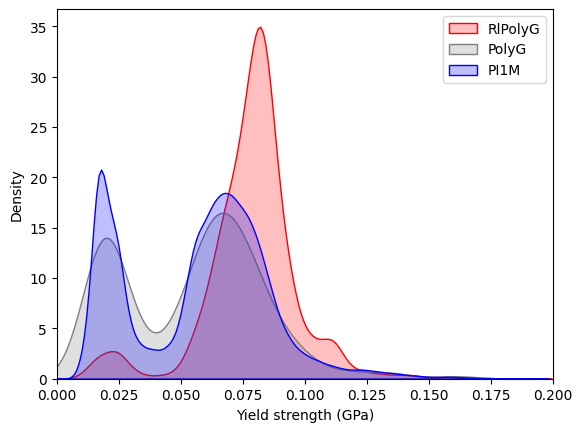

In [64]:
sns.kdeplot(prediction_biased_max,label='RlPolyG', shade=True, color='red')
sns.kdeplot(prediction_unbiased, label='PolyG', shade=True, color='grey')
sns.kdeplot(df_PI1M_v2['yield_strength1'], label='PI1M', shade=True, color='blue')
plt.xlabel('Yield strength (GPa)')
plt.legend()
#plt.show()
plt.xlim(0,0.2)
plt.savefig('Yield strength distribution.png',dpi=300)

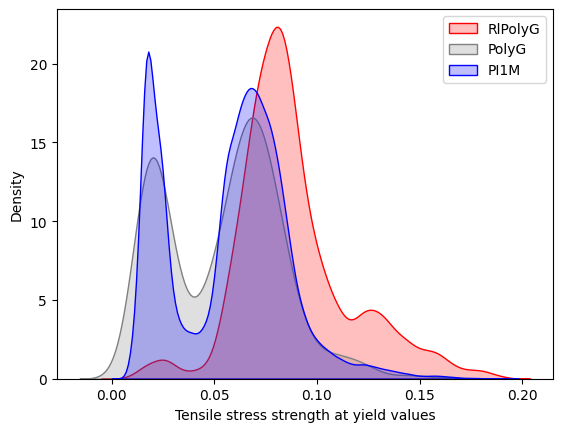

In [283]:
# sns.kdeplot(prediction_biased_max,label='RlPolyG', shade=True, color='red')
# sns.kdeplot(prediction_unbiased, label='PolyG', shade=True, color='grey')
# sns.kdeplot(df_PI1M_v2['yield_strength1'], label='PI1M', shade=True, color='blue')
# plt.xlabel('Yield strength (GPa)')
# plt.legend()
# plt.show()

In [65]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.jointplot(x='yield_strength1', y='SA Score',data= df_PI1M_v2, 
              kind="kde",
)
plt.show()

##### SAscore is used to  estimate how hard (10.000) or how easy (1.000) it may be to synthesize a given molecule.
We use an SA score <5.000 as a criterion for selecting candidate p-SMILES for further validation

In [126]:
import sys
sys.path.append('./proprety_predict/')

from SAscore import sa_score

In [127]:
df_generate['SAscore']=df_generate['SMILES'].apply(sa_score) 

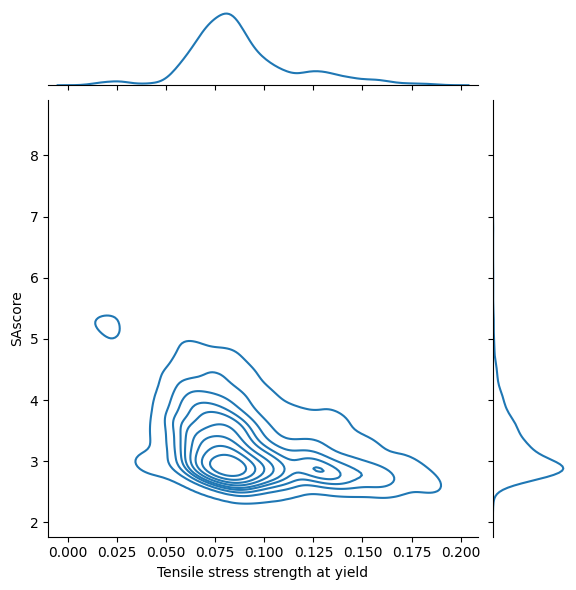

In [67]:
sns.jointplot(x='Tensile stress strength at yield', y='SAscore',data= df_generate, 
              kind="kde",
)
plt.show()

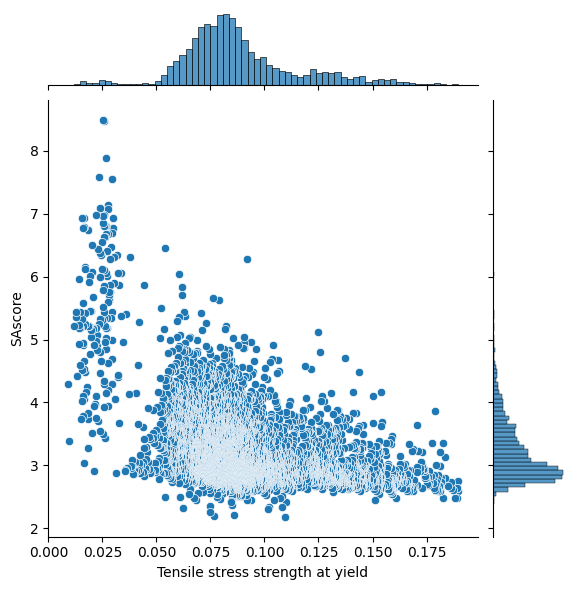

In [76]:
sns.jointplot(x='Tensile stress strength at yield', y='SAscore',data= df_generate)

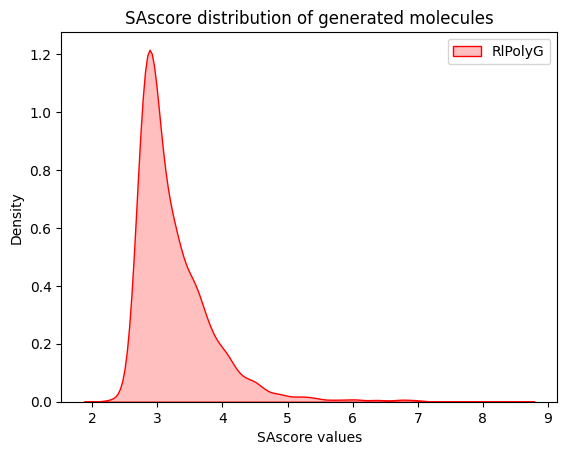

In [68]:
sns.kdeplot(df_generate['SAscore'],label='RlPolyG', shade=True, color='red')
plt.xlabel('SAscore values')
plt.legend()
plt.title('SAscore distribution of generated molecules')
plt.show()

In [251]:
sa_score('*Nc1ccc(-c2ccc(C(*)=O)cc2)cc1')

2.9464358126097867

In [252]:
sa_score('[*]Nc1ccc(Oc2ccc(C([*])=O)cc2)cc1')

2.9250326205620496

In [60]:
sa_score('*Oc1c(C)cc(C(*)=O)cc1C')

3.8496361300993236

In [61]:
df_PI1M_v2=pd.read_csv('/home/cbe/AI4CHEM/polymer_design/ReLeaSE/data/PI1M_v2.csv')

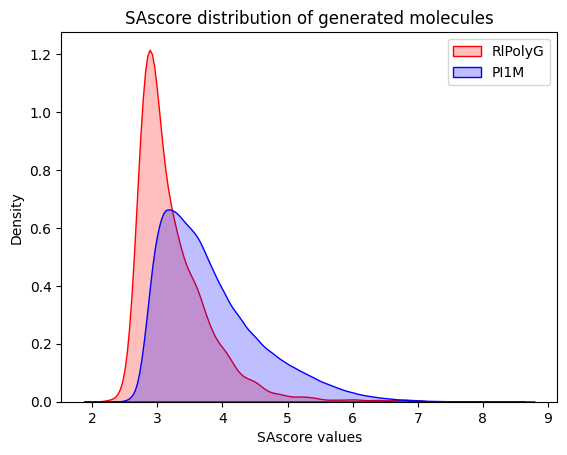

In [254]:
sns.kdeplot(df_generate['SAscore'],label='RlPolyG', shade=True, color='red')
sns.kdeplot(df_PI1M_v2['SA Score'],label='PI1M', shade=True, color='blue')
plt.xlabel('SAscore values')
plt.legend()
plt.title('SAscore distribution of generated molecules')
plt.show()

In [128]:
import pickle
with open('/home/cbe/AI4CHEM/polymer_design/ReLeaSE/proprety_predict/rf_mfp_degradability.pkl', 'rb') as f:
    rf_degradability = pickle.load(f)

In [129]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
def get_Morgan_fingerprint_frequency(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        info={}
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,3,nBits=2048,bitInfo=info)
        key=[key for key in info.keys()]
        frq=[len(value) for value in info.values()]
        new_info={key: value for key, value in zip(key, frq)}
        mff=[0] * len(list(fp))
        for key, value in new_info.items():
            mff[key] = value
    except:
        mff=None
    return mff

def get_degradability_predict(smi):
    X_screen=get_Morgan_fingerprint_frequency(smi)
    #print(X_screen)
    X_screen=np.reshape(X_screen,(1,-1))
    pred=rf_degradability.predict(X_screen)
    pred=pred[0]
    return pred 

In [32]:
get_degradability_predict('*Nc1ccc(-c2ccc(C(*)=O)cc2)cc1')

0.47618254523374776

In [78]:
get_degradability_predict('[*]Nc1ccc(Oc2ccc(C([*])=O)cc2)cc1')

0.4084858145571716

In [101]:
get_degradability_predict('[*]Nc1ccc(NCc2ccc(C([*])=O)cc2)cc1')

0.4627646725059676

In [84]:
get_degradability_predict('*c1ccc(N2C(=O)c3ccc(S(=O)(=O)c4ccc5c(c4)C(=O)N(*)C5=O)cc3C2=O)cc1')

0.6737830075560793

In [6]:
get_degradability_predict('*Oc1c(C)cc(C(*)=O)cc1C')

0.7675836004363015

In [140]:
get_degradability_predict('*Nc1ccc(NC(=S)c2ccc(C(*)=O)cc2)cc1')

0.4117832037325644

In [153]:
# data_add_MD=pd.read_excel('/home/cbe/AI4CHEM/polymer_design_v1/ReLeaSE/RLPolyG_ADD_MD_0625.xlsx')

In [151]:
# data_add_MD['standard_SMILES']=data_add_MD['SMILES'].apply(get_standard_smiles)
# data_add_MD['novelty']=data_add_MD['standard_SMILES'].apply(judege_new_polymer)
# data_add_MD['polyinfo_novelty']=data_add_MD['standard_SMILES'].apply(judege_new_polymer_polyinfo)

In [154]:
#data_add_MD

In [93]:
#data_add_MD['degradability']=data_add_MD['SMILES'].apply(get_degradability_predict)

In [143]:
#data_add_MD['SAScore']=data_add_MD['SMILES'].apply(sa_score) 

In [130]:
df_generate['degradability']=df_generate['SMILES'].apply(get_degradability_predict)

In [131]:
#df_generate.to_csv('RLPolyG_tensile_stress_strength_at_yield_v0625.csv',index=False)

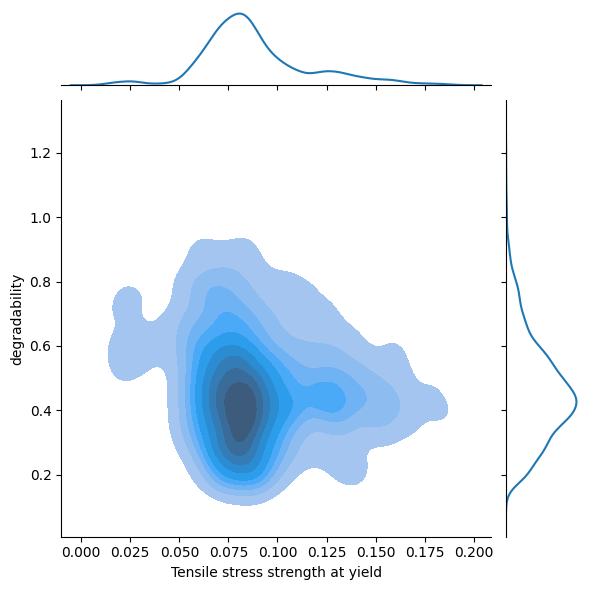

In [74]:
sns.jointplot(x='Tensile stress strength at yield', y='degradability',data= df_generate, 
              kind="kde",
              shade = True
)
plt.show()

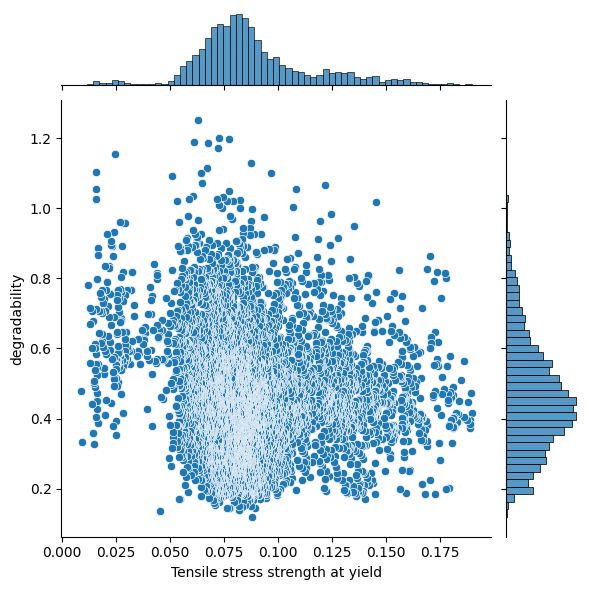

In [75]:
sns.jointplot(x='Tensile stress strength at yield', y='degradability',data= df_generate)

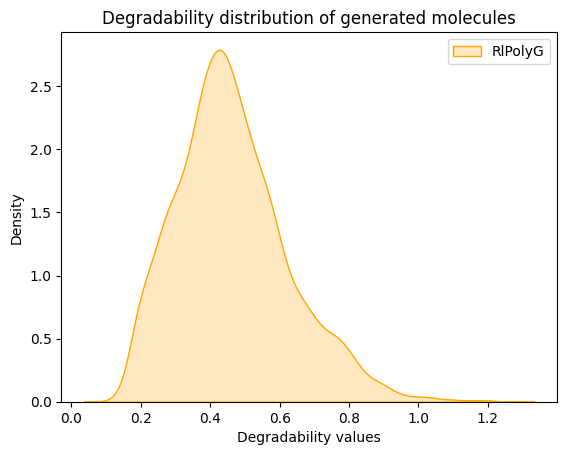

In [73]:
sns.kdeplot(df_generate['degradability'],label='RlPolyG', shade=True, color='orange')
plt.xlabel('Degradability values')
plt.legend()
plt.title('Degradability distribution of generated molecules')
plt.show()

In [261]:
df_PI1M_v2['degradability']=df_PI1M_v2['SMILES'].apply(get_degradability_predict)

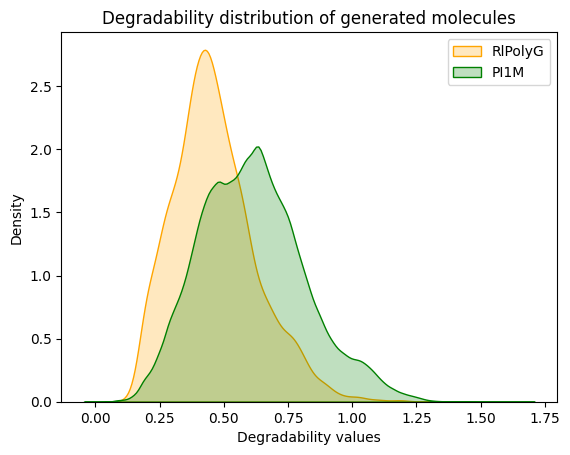

In [263]:
sns.kdeplot(df_generate['degradability'],label='RlPolyG', shade=True, color='orange')
sns.kdeplot(df_PI1M_v2['degradability'],label='PI1M', shade=True, color='green')
plt.xlabel('Degradability values')
plt.legend()
plt.title('Degradability distribution of generated molecules')
plt.show()

In [207]:
# df_generate_sort = df_generate.sort_values('Tensile stress strength at yield', ascending=False)
# df_generate_sort.to_csv('df_generate_sort.csv',index=False)

In [164]:
df_generate_final_select=df_generate[(df_generate['novelty']==1) & (df_generate['polyinfo_novelty']==1) & (df_generate['degradability'] >= 0.303)& (df_generate['SAscore'] <= 5)& (df_generate['Tensile stress strength at yield'] >= 0.1)]

In [165]:
df_generate_final_select

,SMILES,Tensile stress strength at yield,novelty,polyinfo_novelty,SAscore,degradability,standard_SMILES
4514,*Nc1ccc(Nc2ccccc2NC(=O)c2ccc(C(*)=O)cc2)cc1,0.185658,1,1,2.713891,0.428549,*Nc1ccc(Nc2ccccc2NC(=O)c2ccc(C(*)=O)cc2)cc1
4501,*Nc1ccc(NC(=S)c2ccc(C(*)=O)cc2)cc1,0.183453,1,1,3.134041,0.411783,*Nc1ccc(NC(=S)c2ccc(C(*)=O)cc2)cc1
4439,*Nc1ccc(NC(=O)c2ccc(NC(=O)c3cc(C(*)=O)cc(C(=O)...,0.177315,1,1,2.762753,0.668228,*Nc1ccc(NC(=O)c2ccc(NC(=O)c3cc(C(*)=O)cc(C(=O)...
4465,*Nc1ccc(NC(=O)c2cccc(Cc3cccc(C(*)=O)c3)c2)cc1,0.176989,1,1,2.735079,0.592031,*Nc1ccc(NC(=O)c2cccc(Cc3cccc(C(*)=O)c3)c2)cc1
4506,*Nc1ccc(Nc2ccc(/N=C/c3ccc(C(*)=O)cc3)cc2)cc1,0.173601,1,1,2.985726,0.459154,*Nc1ccc(Nc2ccc(/N=C/c3ccc(C(*)=O)cc3)cc2)cc1
...,...,...,...,...,...,...,...
3455,*NC(=C=CNC(=O)c1ccccc1C(*)=O)c1ccccc1,0.100066,1,1,3.616696,0.533202,*NC(=C=CNC(=O)c1ccccc1C(*)=O)c1ccccc1
245,*/C=C/c1ccc(*)cc1OC(C)c1ccccc1,0.100053,1,1,3.901244,0.576411,*/C=C/c1ccc(*)cc1OC(C)c1ccccc1
385,*/N=C/c1ccc(C(=O)Nc2ccc(C(*)=O)cc2)cc1,0.100052,1,1,2.859858,0.431646,*/N=C/c1ccc(C(=O)Nc2ccc(C(*)=O)cc2)cc1
3625,*NC(CSC(=O)c1ccccc1)C(*)Sc1ccccc1,0.100016,1,1,3.969863,0.352403,*NC(CSC(=O)c1ccccc1)C(*)Sc1ccccc1
